# A2. State preparation with Jaynes-Cummings controls for 4-legged cat state

In [1]:
# ruff: noqa
import os

os.sys.path.append("../../../../..")

In [2]:
from feedback_grape.fgrape import optimize_pulse_with_feedback
from feedback_grape.utils.operators import (
    sigmap,
    sigmam,
    create,
    destroy,
    identity,
)
from feedback_grape.utils.states import basis, fock
from feedback_grape.utils.tensor import tensor
import jax.numpy as jnp
from jax.scipy.linalg import expm

As a preliminary step, we consider state preparation
of a target state starting from a pure state. In addition,
we assume that any coupling to an external environment
is negligible and that the parametrized controls can be
implemented perfectly.

Here no feedback is required, we are just testing the parameterized gates setup.

As a first example, we consider the state preparation
of a cavity resonantly coupled to an externally driven
qubit

Here, we consider a particular sequence of
parametrized unitary gates originally introduced by Law
and Eberly

In [3]:
from feedback_grape.new_api.modeling import QubitCavity


N_cav = 40
hs = QubitCavity(1, N_cav)
q = hs.qubits[0]
c = hs.cavities[0]

In [4]:
sigp = q.sigmap
sigm = q.sigmam


def qubit_unitary(alphas):
    alpha = alphas[0] + 1j * alphas[1]
    U = expm(-1j * (alpha * sigp + alpha.conjugate() * sigm) / 2)
    return U

In [5]:
def qubit_unitary_old(alphas):
    alpha_re = alphas[0]
    alpha_im = alphas[1]
    alpha = alpha_re + 1j * alpha_im
    return tensor(
        expm(-1j * (alpha * sigmap() + alpha.conjugate() * sigmam()) / 2),
        identity(N_cav),
    )

In [6]:
jnp.allclose(
    qubit_unitary_old([1.0, 0.6]),
    qubit_unitary([1.0, 0.6]),
)

Array(True, dtype=bool)

In [7]:
a = c.a
adag = c.adag


def qubit_cavity_unitary(betas):
    beta = betas
    H_int = beta * (a @ sigp) + beta.conjugate() * (adag @ sigm)
    return expm(-1j * H_int / 2)

In [8]:
def qubit_cavity_unitary_old(beta_re):
    beta = beta_re
    return expm(
        -1j
        * (
            beta * (tensor(sigmap(), destroy(N_cav)))
            + beta.conjugate() * (tensor(sigmam(), create(N_cav)))
        )
        / 2
    )

In [9]:
jnp.allclose(
    qubit_cavity_unitary_old(jnp.array([1.0])),
    qubit_cavity_unitary(jnp.array([1.0])),
    atol=1e-20,
)  # True

Array(True, dtype=bool)

In their groundbreaking work, Law and Eberly have
shown that any arbitrary superposition of Fock states with
maximal excitation number N can be prepared out of the
ground state in a sequence of N such interleaved gates,
also providing an algorithm to find the correct angles and
interaction durations

## First target is the 4 component cat state 

In [10]:
time_steps = 20

In [11]:
from feedback_grape.utils.states import coherent


psi0 = tensor(basis(2), basis(N_cav))
psi0 = psi0 / jnp.linalg.norm(psi0)
average_photon_number = 9
cat = (
    coherent(N_cav, 3)
    + coherent(N_cav, -3)
    + coherent(N_cav, 1j * 3)
    + coherent(N_cav, -1j * 3)
)
psi_target = tensor(basis(2), cat)
psi_target = psi_target / jnp.linalg.norm(psi_target)

In [12]:
psi0.shape

(80, 1)

In [13]:
psi_target.shape

(80, 1)

In [14]:
print(fock(N_cav, 1))

[[0.+0.j]
 [1.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]
 [0.+0.j]]


Law and Eberly provided an algorithm to determine the correct parameters for state preparation. These include:

- The rotation angle $ |\alpha| $,
- The azimuthal angle $ \arg\left(\frac{\alpha}{|\alpha|}\right) $,
- The interaction duration $ |\beta| $. <br>

So Goal is to find the best control vector (rather than control amplitudes, this time) that leads to finding the optimal state-preparation strategies. Performing as well as the Law-Eberly algorithm.

## Optimizing
Currently l-bfgs with the same learning rate of 0.3 converges at a local minimum of 0.5, adam also converges at 0.5 but at smaller learning rates

In [15]:
from feedback_grape.fgrape import Gate
import jax

key = jax.random.PRNGKey(42)
# not provideing param_constraints just propagates the same initial_parameters for each time step
qub_unitary = Gate(
    gate=qubit_unitary,
    initial_params=jax.random.uniform(
        key,
        shape=(2,),  # 2 for gamma and delta
        minval=-5,
        maxval=5,
        dtype=jnp.float64,
    ),
    measurement_flag=False,
)

qub_cav = Gate(
    gate=qubit_cavity_unitary,
    initial_params=jax.random.uniform(
        key,
        shape=(1,),
        minval=-5,
        maxval=5,
        dtype=jnp.float64,
    ),
    measurement_flag=False,
)

system_params = [qub_unitary, qub_cav]


result = optimize_pulse_with_feedback(
    U_0=psi0,
    C_target=psi_target,
    system_params=system_params,
    num_time_steps=time_steps,
    max_iter=3000,
    convergence_threshold=None,  # 0.0 or None to reach max iterations
    evo_type="state",
    mode="no-measurement",
    goal="fidelity",
    learning_rate=0.01,
    batch_size=10,
    eval_batch_size=1,
    progress=True,
)

Iteration 0, Loss: -0.032482
Iteration 10, Loss: -0.119766
Iteration 20, Loss: -0.218807
Iteration 30, Loss: -0.290923
Iteration 40, Loss: -0.331432
Iteration 50, Loss: -0.363328
Iteration 60, Loss: -0.385187
Iteration 70, Loss: -0.392812
Iteration 80, Loss: -0.398971
Iteration 90, Loss: -0.406213
Iteration 100, Loss: -0.414206
Iteration 110, Loss: -0.424084
Iteration 120, Loss: -0.436752
Iteration 130, Loss: -0.455166
Iteration 140, Loss: -0.483714
Iteration 150, Loss: -0.526234
Iteration 160, Loss: -0.587400
Iteration 170, Loss: -0.658891
Iteration 180, Loss: -0.710771
Iteration 190, Loss: -0.743793
Iteration 200, Loss: -0.767970
Iteration 210, Loss: -0.785470
Iteration 220, Loss: -0.794869
Iteration 230, Loss: -0.799156
Iteration 240, Loss: -0.801985
Iteration 250, Loss: -0.804416
Iteration 260, Loss: -0.806428
Iteration 270, Loss: -0.808274
Iteration 280, Loss: -0.809989
Iteration 290, Loss: -0.811600
Iteration 300, Loss: -0.813111
Iteration 310, Loss: -0.814524
Iteration 320, Loss

In [16]:
result.final_fidelity

Array(0.9974044, dtype=float64)

In [17]:
len(result.returned_params)

20

In [18]:
# here makes sense for each batch size we have a different set of parameters since there are no measurements and therefore no stochasticisty or randomness
result.returned_params

[[Array([[-4.61660173e-06, -5.89077384e+00]], dtype=float64),
  Array([[-3.27063422]], dtype=float64)],
 [Array([[ 5.18620096e-06, -2.77998526e+00]], dtype=float64),
  Array([[2.16741588]], dtype=float64)],
 [Array([[ 2.14855902e-06, -3.49834185e+00]], dtype=float64),
  Array([[1.57679819]], dtype=float64)],
 [Array([[-5.31159708e-07, -2.99800565e+00]], dtype=float64),
  Array([[-1.98594831]], dtype=float64)],
 [Array([[ 1.40137018e-05, -9.48290696e+00]], dtype=float64),
  Array([[-1.58246239]], dtype=float64)],
 [Array([[-2.36044497e-06, -2.97342325e+00]], dtype=float64),
  Array([[-1.15125976]], dtype=float64)],
 [Array([[ 3.16922489e-06, -2.96808757e+00]], dtype=float64),
  Array([[-1.07001966]], dtype=float64)],
 [Array([[ 2.71478944e-07, -3.72165856e+00]], dtype=float64),
  Array([[-1.68067433]], dtype=float64)],
 [Array([[ 9.71135207e-07, -2.75488414e+00]], dtype=float64),
  Array([[-0.98873756]], dtype=float64)],
 [Array([[ 4.16248803e-06, -4.55093378e+00]], dtype=float64),
  Ar

In [19]:
print(result.final_state)

[[[ 2.21778616e-02+7.75206144e-06j]
  [ 5.93676589e-08+1.25538099e-05j]
  [ 6.36205563e-05+1.58475981e-08j]
  [-1.01291899e-07-1.16493814e-04j]
  [ 3.68007620e-01+1.29130101e-04j]
  [ 2.64025754e-08-2.72300451e-05j]
  [ 2.73748099e-05-1.80751161e-08j]
  [-1.28358573e-07-2.66308618e-05j]
  [ 7.27252730e-01+2.54790185e-04j]
  [-9.15181168e-08+5.18094227e-04j]
  [-3.04168662e-04+4.17325710e-08j]
  [-4.76996648e-08+5.20693471e-04j]
  [ 5.39522381e-01+1.89057638e-04j]
  [ 1.00242515e-07-3.80256290e-04j]
  [-1.84083041e-04-1.42388425e-07j]
  [ 6.50646846e-07-1.14785970e-03j]
  [ 2.09843403e-01+7.37100867e-05j]
  [-6.03178995e-08+2.84291395e-05j]
  [ 6.01304451e-03+2.11519867e-06j]
  [-5.74166180e-08+1.64615744e-04j]
  [ 0.00000000e+00+0.00000000e+00j]
  [ 0.00000000e+00+0.00000000e+00j]
  [ 0.00000000e+00+0.00000000e+00j]
  [ 0.00000000e+00+0.00000000e+00j]
  [ 0.00000000e+00+0.00000000e+00j]
  [ 0.00000000e+00+0.00000000e+00j]
  [ 0.00000000e+00+0.00000000e+00j]
  [ 0.00000000e+00+0.0000000

In [20]:
from feedback_grape.utils.fidelity import fidelity, ket2dm


fidelity(
    U_final=result.final_state[0],
    C_target=ket2dm(psi_target),
    evo_type="density",
)

Array(0.99740442, dtype=float64)

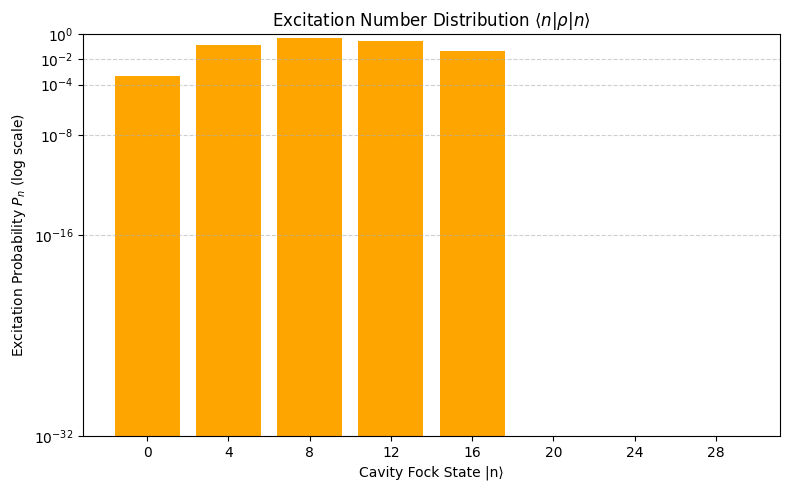

In [21]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
from feedback_grape.utils.operators import identity
from feedback_grape.utils.tensor import tensor
from feedback_grape.utils.states import (
    fock,
)  # Assuming this provides the Fock state function

# Parameters
target_levels = [0, 4, 8, 12, 16, 20, 24, 28]

# Projectors and probabilities
probs = []
for n in target_levels:
    # Projector: |n⟩⟨n| ⊗ I_qubit
    # probability that the final state is in the projection subspace of the
    # cavity Fock state |n⟩
    proj = tensor(ket2dm(basis(2)), ket2dm(fock(N_cav, n)))
    prob = jnp.real(
        jnp.vdot(result.final_state[0], proj @ result.final_state[0])
    )
    probs.append(prob)

# Plotting
plt.figure(figsize=(8, 5))
plt.bar([str(n) for n in target_levels], probs, color='orange')
plt.yscale('log')
plt.yticks(
    [1e-32, 1e-16, 1e-8, 1e-4, 1e-2, 1e0],
    labels=[
        '$10^{-32}$',
        '$10^{-16}$',
        '$10^{-8}$',
        '$10^{-4}$',
        '$10^{-2}$',
        '$10^0$',
    ],
)
plt.xlabel('Cavity Fock State |n⟩')
plt.ylabel('Excitation Probability $P_n$ (log scale)')
plt.title('Excitation Number Distribution $\\langle n | \\rho | n \\rangle$')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()